In [1]:
import pandas as pd
import unicodedata
import string
import re
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.metrics import precision_recall_curve,precision_score,recall_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn import feature_extraction,naive_bayes,pipeline,manifold,preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_selection

from lime import lime_text
import gensim
import gensim.downloader as gensim_api

# from tensorflow.keras import models,layers,preprocessing as kprocessing
# from tensorflow.keras import backend as K

# import transformers

import numpy as np

/home/ubuntu/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
col_names = ['target','question_title','question_content','best_answer']
target_classes = ['Society & Culture','Science & Mathematics','Health','Education & Reference',
                  'Computers & Internet','Sports','Business & Finance','Entertainment & Music',
                  'Family & Relationships','Politics & Government']
target_classes_dict = {1:'Society & Culture',
                       2:'Science & Mathematics',
                       3:'Health',
                       4:'Education & Reference',
                       5:'Computers & Internet',
                       6:'Sports',
                       7:'Business & Finance',
                       8:'Entertainment & Music',
                       9:'Family & Relationships',
                       10:'Politics & Government'}

In [3]:
df = pd.read_csv('data_yahoo/train.csv',header=None,names=col_names)
# df_test = pd.read_csv('data_yahoo/test.csv',header=None,names=col_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   target            1400000 non-null  int64 
 1   question_title    1400000 non-null  object
 2   question_content  768325 non-null   object
 3   best_answer       1375421 non-null  object
dtypes: int64(1), object(3)
memory usage: 42.7+ MB


In [4]:
df.head()

,target,question_title,question_content,best_answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [5]:
def get_samples(df, num_samples):
    idx_lst = list(range(len(df)))
    idx_samps = random.sample(idx_lst, num_samples)
    df_samp = df.iloc[idx_samps]
    return df_samp

### Sampling the dataset since I'm running that on my computer. 
**** NEED to remove that in AWS

In [6]:
df = get_samples(df,300000)

In [7]:
df.question_content.fillna(value='',axis=0,inplace=True)
df.best_answer.fillna(value='',axis=0,inplace=True)

In [8]:
df.shape

(300000, 4)

In [9]:
df['Q'] = df.question_title + df.question_content
df['Q&A'] = df.question_title + df.question_content + df.best_answer

In [10]:
df.head(5)

,target,question_title,question_content,best_answer,Q,Q&A
1258846,4,"i would like to know what day, month, and year...",,"350,000 days = 958 non-leap years, 330 days.\n...","i would like to know what day, month, and year...","i would like to know what day, month, and year..."
1232104,2,what percent of fingerpring matches are false ...,,none all fingerprints are unique,what percent of fingerpring matches are false ...,what percent of fingerpring matches are false ...
1133312,8,Not sure if any of you read this before...?,"Mr Honda, of the Honda Motorcycle Corporation,...","Good one, and no, never heard it before.",Not sure if any of you read this before...?Mr ...,Not sure if any of you read this before...?Mr ...
1372500,8,How do people wiggle their ears?,,I can do this. You have to relax and then ten...,How do people wiggle their ears?,How do people wiggle their ears?I can do this....
1354842,4,Why does it seem that so many people today are...,Should concern for proper grammar and correct ...,me am not to be undersatnd youre qestion. what...,Why does it seem that so many people today are...,Why does it seem that so many people today are...


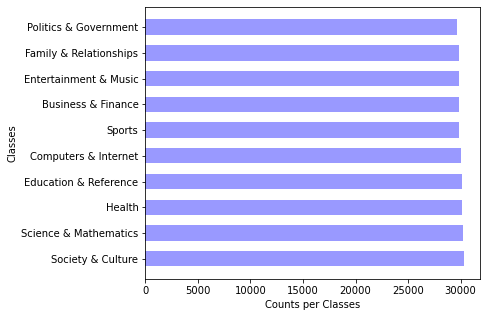

In [11]:
fig,ax = plt.subplots(figsize=(6,5));
ax.barh(y = target_classes,width=df.target.value_counts().values,color='b',alpha=0.4,height=0.6);
ax.set_ylabel('Classes');
ax.set_xlabel('Counts per Classes');

In [12]:
# df['lang'] = df['Q&A'].apply(lambda x:langdetect.detect(x) if x.strip()!="" else "")

In [13]:
lst_stopwords = stopwords.words('english')

In [14]:
def text_cleaning(text,stem_flag=False,lem_flag=True,lst_stopwords=None):
    text = text.replace('\\n',' ')
    text = text.replace('\n',' ')
    text = re.sub(r'[^\w\s]',' ',str(text).lower().strip())
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", str(text).lower().strip())
    text = re.sub(' 0 ',' ',str(text).lower().strip())
    text = re.sub(' 00 ',' ',str(text).lower().strip())
    text = re.sub(' 000 ',' ',str(text).lower().strip())
    
    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if stem_flag == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    if lem_flag == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    lst_text = " ".join(lst_text)
    return lst_text

In [15]:
df['Text_new'] = df['Q&A'].apply(lambda x:text_cleaning(x,stem_flag=False,lem_flag=True,lst_stopwords=lst_stopwords))

In [16]:
df.head(10)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new
1258846,4,"i would like to know what day, month, and year...",,"350,000 days = 958 non-leap years, 330 days.\n...","i would like to know what day, month, and year...","i would like to know what day, month, and year...",would like know day month year would day today...
1232104,2,what percent of fingerpring matches are false ...,,none all fingerprints are unique,what percent of fingerpring matches are false ...,what percent of fingerpring matches are false ...,percent fingerpring match false positive none ...
1133312,8,Not sure if any of you read this before...?,"Mr Honda, of the Honda Motorcycle Corporation,...","Good one, and no, never heard it before.",Not sure if any of you read this before...?Mr ...,Not sure if any of you read this before...?Mr ...,sure read mr honda honda motorcycle corporatio...
1372500,8,How do people wiggle their ears?,,I can do this. You have to relax and then ten...,How do people wiggle their ears?,How do people wiggle their ears?I can do this....,people wiggle ear relax tense scalp muscle tak...
1354842,4,Why does it seem that so many people today are...,Should concern for proper grammar and correct ...,me am not to be undersatnd youre qestion. what...,Why does it seem that so many people today are...,Why does it seem that so many people today are...,seem many people today embarassed bad grammar ...
1183087,4,is it better to get a diploma or a GED?,i got expelled from school and i could get my ...,This may sound weird. \n\n If I were in your ...,is it better to get a diploma or a GED?i got e...,is it better to get a diploma or a GED?i got e...,better get diploma ged got expelled school cou...
768519,4,When are the isc results 2006 being declared a...,,today,When are the isc results 2006 being declared a...,When are the isc results 2006 being declared a...,isc result declared time today
1314210,10,Stop Africans migrating to Europe or face the ...,"Africans say, we can stand to see others enjoy...",Too True. Why not? the 'West' continue to enjo...,Stop Africans migrating to Europe or face the ...,Stop Africans migrating to Europe or face the ...,stop african migrating europe face headache af...
1034944,6,shall i go to the pub and watch football?,or shall i stay in and get to bed early ready ...,"get to the pub, have a good night",shall i go to the pub and watch football?or sh...,shall i go to the pub and watch football?or sh...,shall go pub watch football shall stay get bed...
285969,10,How does war change people's relationships?,,depends on the person. i am against the war co...,How does war change people's relationships?,How does war change people's relationships?dep...,war change people relationship depends person ...


In [17]:
df['word_count'] = df['Q&A'].apply(lambda x:len(str(x).split(" ")))
df['char_count'] = df['Q&A'].apply(lambda x: sum(len(word)for word in str(x).split(" ")))
df['sentence_count'] = df['Q&A'].apply(lambda x:len(str(x).split(".")))
df['word_length'] = df['char_count']/df['word_count']
df['word_per_sentence'] = df['word_count']/df['sentence_count']

In [18]:
df.head(2)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new,word_count,char_count,sentence_count,word_length,word_per_sentence
1258846,4,"i would like to know what day, month, and year...",,"350,000 days = 958 non-leap years, 330 days.\n...","i would like to know what day, month, and year...","i would like to know what day, month, and year...",would like know day month year would day today...,52,249,4,4.788462,13.0
1232104,2,what percent of fingerpring matches are false ...,,none all fingerprints are unique,what percent of fingerpring matches are false ...,what percent of fingerpring matches are false ...,percent fingerpring match false positive none ...,12,76,1,6.333333,12.0


In [19]:
colors=['b','g','r','k','magenta','orange','aqua','violet','peachpuff','pink']
len(colors)

10

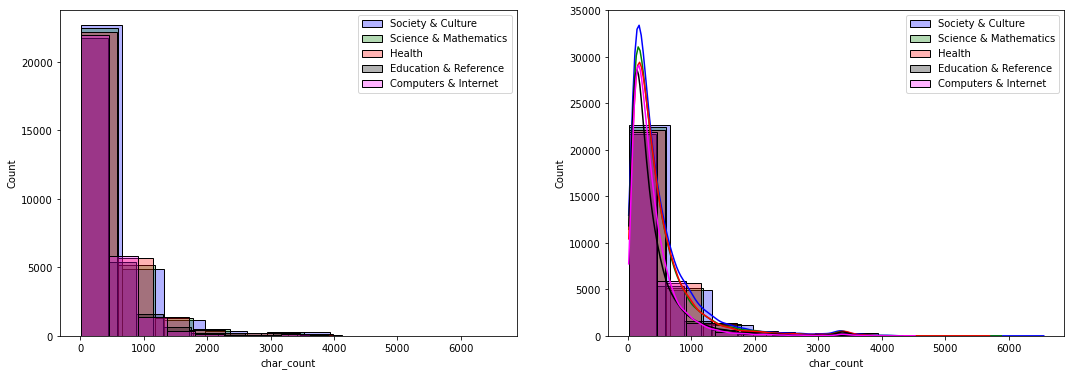

In [20]:
plt_list = ['word_count','char_count','sentence_count','word_length','word_per_sentence']
fig,ax = plt.subplots(1,2,figsize=(18,6))
for i in range(5):#df.target.unique():
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=False,bins=10,ax=ax[0],alpha=0.3,color=colors[i],label=target_classes[i]);
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=True,bins=10,ax=ax[1],alpha=0.3,color=colors[i],label=target_classes[i]);
ax[0].legend();
ax[1].legend();
plt.show();

In [21]:
df.groupby('target').word_count.median()

target
1     71
2     66
3     74
4     51
5     59
6     45
7     53
8     41
9     75
10    72
Name: word_count, dtype: int64

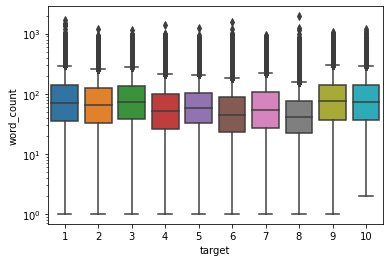

In [22]:
ax = sns.boxplot(x="target", y="word_count", data=df)
ax.set_yscale('log')

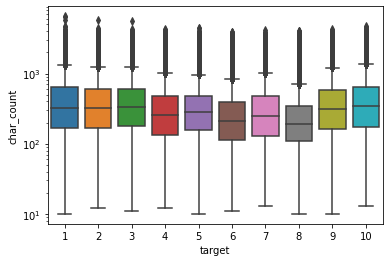

In [23]:
ax = sns.boxplot(x="target", y="char_count", data=df)
ax.set_yscale('log')

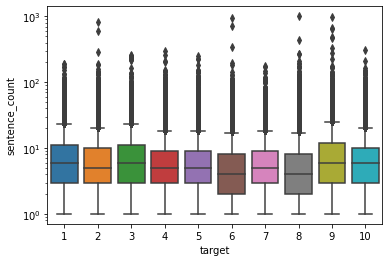

In [24]:
ax = sns.boxplot(x="target", y="sentence_count", data=df)
ax.set_yscale('log')

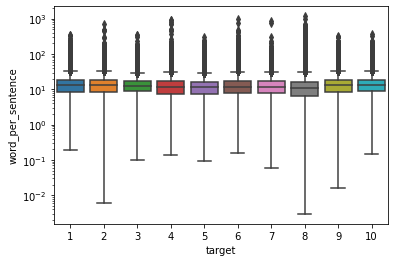

In [25]:
ax = sns.boxplot(x="target", y="word_per_sentence", data=df)
ax.set_yscale('log')

### Tf-idf Method for text classification

In [26]:
X = df.Text_new
y = df.target

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.1,random_state=20)

In [28]:
vect = TfidfVectorizer(max_features=5000,ngram_range=(1,2))

In [29]:
XX_train = vect.fit_transform(X_train)

In [30]:
XX_test = vect.transform(X_test)

In [31]:
vocab = vect.vocabulary_

In [32]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [33]:
X_names = vect.get_feature_names()
df_features = pd.DataFrame()
for category in np.unique(y_train):
    chi2,p = feature_selection.chi2(XX_train,y_train==category)
    df_features = df_features.append(pd.DataFrame({'feature':X_names,'Score':1-p,"y":category}))
    df_features = df_features.sort_values(["y","Score"],ascending=[True,False])
    df_features = df_features[df_features.Score>0.95]

X_names_unique = df_features.feature.unique().tolist()
len(X_names_unique)

4891

In [34]:
df_features.head(5)

,feature,Score,y
42,abraham,1.0,1
52,accent,1.0,1
53,accept,1.0,1
80,adam,1.0,1
142,allah,1.0,1


In [35]:
for category in np.unique(y_train):
    print(f'category {category}:',target_classes[category-1])
    print(f'length of category {category}:',len(df_features[df_features.y==category]))
    print(",".join(df_features[df_features.y==category].feature[:30]))
    print("")

category 1: Society & Culture
length of category 1: 2139
abraham,accent,accept,adam,allah,ancient,angel,arabic,atheist,being,belief,believe,believe god,believer,believing,bible,bible say,biblical,black,black people,bless,blessed,blessing,book,born,catholic,catholic church,celebrate,chinese,christ

category 2: Science & Mathematics
length of category 2: 3103
10,25,2x,3x,4x,5x,6x,acceleration,acid,air,algebra,american,amount,analysis,angle,animal,ant,anyone,area,ask,atmosphere,atom,atomic,axis,bacteria,bad,balloon,bang,base,beam

category 3: Health
length of category 3: 2837
ab,abnormal,acid,acne,active,addiction,affect,aid,alcohol,allergic,allergy,also,american,ankle,antibiotic,anxiety,appointment,arm,arthritis,asleep,avoid,bacteria,bad,bath,bed,belly,best way,bigger,bipolar,birth

category 4: Education & Reference
length of category 4: 1816
academic,admission,algebra,ap,art,assignment,attend,author,bachelor,biology,book,campus,career,class,classroom,college,course,degree,dictionary,dip

In [36]:
vect = TfidfVectorizer(vocabulary=X_names_unique)

In [37]:
XX_train = vect.fit_transform(X_train)
XX_train.shape

(270000, 4891)

In [38]:
XX_test = vect.transform(X_test)

In [39]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [40]:
# Creating a cloud of words

In [41]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')

In [42]:
Text = " ".join(df_features[df_features.y==6].feature[:30])
Text

'2nd allen argentina arsenal athlete atlanta au australia ball baseball basketball bat bay bear beat ben bench best better bike boat boston bowl boxing brasil brazil bull business captain carolina'

In [43]:
wordcloud = WordCloud(width=1000,height=880,random_state=1,background_color='black',colormap='Set2',
                      collocations=False,stopwords=lst_stopwords).generate(Text)

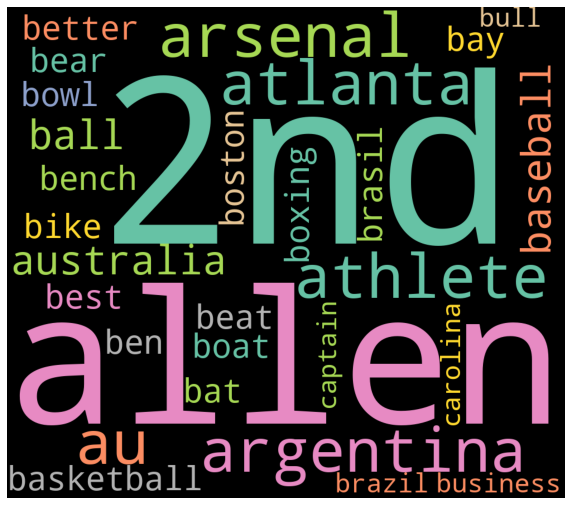

In [44]:
plot_cloud(wordcloud)

In [45]:
cvec = CountVectorizer(max_features=5000, ngram_range=(1, 2),stop_words='english')

In [46]:
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec  = cvec.transform(X_test)

### Naive Bayes Classifier
In this section, we used Naive bayes classifer to fit our model to training data

In [47]:
nb = naive_bayes.MultinomialNB()

In [48]:
# # pipeline
# model = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",nb)])

In [49]:
cross_val_score(nb,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6648740740740741

In [50]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
nb.fit(XX_train,y_train)

MultinomialNB()

In [51]:
## Test Classifier
Predicted = nb.predict(XX_test)
Predicted_prob = nb.predict_proba(XX_test)

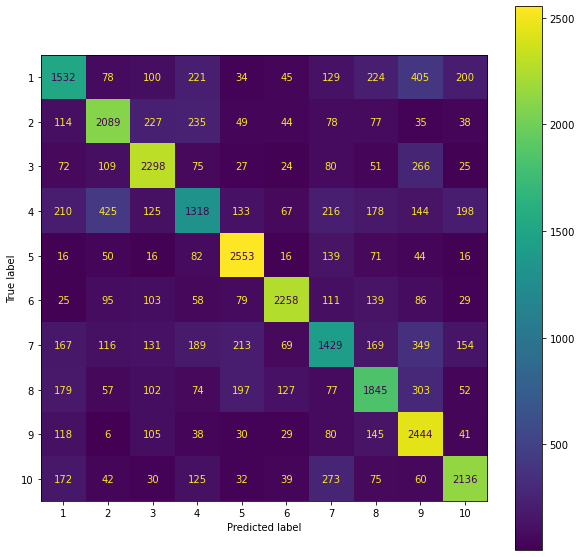

In [52]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(nb,XX_test,y_test,ax=ax);

In [53]:
cross_val_score(nb,X_train_cvec,y_train,cv=5,n_jobs=-1).mean()

0.6592

## Logistic Regression Classifier
In this section, we used logistic classifer to fit our model to training data

In [54]:
model_lr = LogisticRegression(max_iter=5000)

In [55]:
# # pipeline
# model_lr = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",lr)])

In [56]:
cross_val_score(model_lr,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6816407407407408

In [57]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
model_lr.fit(XX_train,y_train)

LogisticRegression(max_iter=5000)

In [58]:
## Test Classifier
Predicted = model_lr.predict(XX_test)
Predicted_prob = model_lr.predict_proba(XX_test)

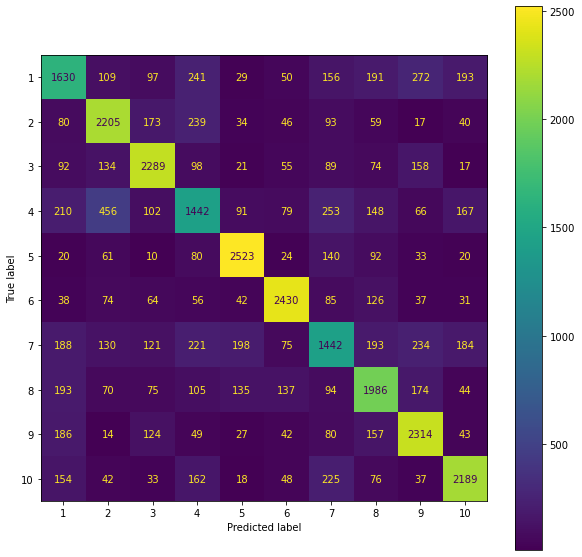

In [59]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_lr,XX_test,y_test,ax=ax);

## Random Forest Classifier
In this section, we will use random forest classiier to fit our model to the training dataset

In [ ]:
model_rf = RandomForestClassifier(n_estimators=2000,max_depth=30,n_jobs=-1)

In [ ]:
# # pipeline
# model_rf = pipeline.Pipeline([("vectorizer",vect),
#                               ("classifier",rf)])

In [ ]:
cross_val_score(model_rf,XX_train,y_train,cv=5,n_jobs=-1).mean()

In [ ]:
model_rf.fit(XX_train,y_train)

In [ ]:
## Test Classifier
Predicted_rf = model_rf.predict(XX_test)
Predicted_prob_rf = model_rf.predict_proba(XX_test)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_rf,XX_test,y_test,ax=ax);

In [ ]:
feature_names = list(X_names_unique)
feature_scores = pd.DataFrame({'Mean Decrease Impurity' : model_rf.feature_importances_}, index=feature_names)
feature_scores = feature_scores.sort_values(by='Mean Decrease Impurity', ascending=False)[:20]
feature_scores.plot(kind='barh', color = 'b', alpha=0.3, figsize=(8,8))
ax = plt.gca().invert_yaxis()
leg = plt.legend( loc = 'lower right')

In [ ]:
classes = np.unique(y_test)
y_test_dummy = pd.get_dummies(y_test).values

accuracy = accuracy_score(y_test,Predicted)
auc = roc_auc_score(y_test,Predicted_prob,multi_class='ovr')

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(18,7.5))
for i in range(10):
    # ROC Curve
    fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],Predicted_prob[:,i])
    axs[0].plot(fpr,tpr,lw=3,label=target_classes[i],color=colors[i])
    axs[0].plot([0,1],[0,1],color='k',ls='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()
    axs[0].set_title('ROC Curve')
    # Precision-Recall Curve
    precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],Predicted_prob[:,i])
    axs[1].plot(recall,precision,label=target_classes[i],color=colors[i])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-Recall Curve')
    axs[1].legend()
    

### GridSearch CV

In [110]:
opt_model = pipeline.Pipeline([
           ('vectopt', TfidfVectorizer()),
           ('classifier', model_lr)])

In [111]:
parameters = {
    'vectopt__max_df': (0.98, 1.0),
    'vectopt__min_df': (0.01, 0.02 ),
    'vectopt__max_features': (2000, 5000, 10000),
    'vectopt__ngram_range': ((1, 1), (1, 2), (1,3))  
                }

In [112]:
# lr_gs = GridSearchCV(opt_model,param_grid=parameters,cv=2,verbose=1,scoring='accuracy',n_jobs=-1)
lr_gs = GridSearchCV(opt_model,param_grid=parameters,cv=5,verbose=1,n_jobs=-1)

In [ ]:
lr_gs.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.


In [99]:
e = pd.DataFrame(lr_gs.cv_results_)

In [104]:
e.sort_values(by='mean_test_score',axis=0,ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vectopt__max_df,param_vectopt__max_features,param_vectopt__min_df,param_vectopt__ngram_range,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
1,65.699461,1.052816,10.067201,1.407657,0.98,2000,0.01,"(1, 2)","{'vectopt__max_df': 0.98, 'vectopt__max_featur...",0.566874,0.564444,0.565659,0.001215,1
2,109.451415,2.154058,12.584241,0.056680,0.98,2000,0.01,"(1, 3)","{'vectopt__max_df': 0.98, 'vectopt__max_featur...",0.566874,0.564444,0.565659,0.001215,1
32,108.044366,5.137068,12.061401,0.740423,1,10000,0.01,"(1, 3)","{'vectopt__max_df': 1.0, 'vectopt__max_feature...",0.566874,0.564444,0.565659,0.001215,1
31,68.789744,1.768978,8.484592,0.101755,1,10000,0.01,"(1, 2)","{'vectopt__max_df': 1.0, 'vectopt__max_feature...",0.566874,0.564444,0.565659,0.001215,1
26,109.416539,1.750828,11.853248,0.023738,1,5000,0.01,"(1, 3)","{'vectopt__max_df': 1.0, 'vectopt__max_feature...",0.566874,0.564444,0.565659,0.001215,1
7,68.094164,0.558520,10.153522,1.427916,0.98,5000,0.01,"(1, 2)","{'vectopt__max_df': 0.98, 'vectopt__max_featur...",0.566874,0.564444,0.565659,0.001215,1
8,107.452776,2.136446,12.385799,0.121605,0.98,5000,0.01,"(1, 3)","{'vectopt__max_df': 0.98, 'vectopt__max_featur...",0.566874,0.564444,0.565659,0.001215,1
25,70.405002,4.431756,8.577147,0.045715,1,5000,0.01,"(1, 2)","{'vectopt__max_df': 1.0, 'vectopt__max_feature...",0.566874,0.564444,0.565659,0.001215,1
20,110.960746,1.488968,12.010169,0.025215,1,2000,0.01,"(1, 3)","{'vectopt__max_df': 1.0, 'vectopt__max_feature...",0.566874,0.564444,0.565659,0.001215,1
19,68.339333,1.602056,8.562168,0.017590,1,2000,0.01,"(1, 2)","{'vectopt__max_df': 1.0, 'vectopt__max_feature...",0.566874,0.564444,0.565659,0.001215,1


### USE THE BELOW LINES FOR DEBUGGING

In [64]:
lr_test = LogisticRegression(max_iter=5000)
# pipeline
model_test = pipeline.Pipeline([("vectorizer",vect),
                                ("classifier",lr_test)])
model_test.fit(X_train,y_train)
## Test Classifier
Predicted_test = model_test.predict(X_test)
Predicted_prob_test = model_test.predict_proba(X_test)

In [65]:
# Testing the error
X_test[y_test!=Predicted].iloc[1]
y_test[y_test!=Predicted]
e = Predicted[y_test!=Predicted]
index_incorrect = X_test[(y_test!=Predicted) & (y_test==7)].index
index_incorrect

Int64Index([ 282538,  190596,  807082,   68729,  977107,   62676,  162793,
             172079,   70980, 1399501,
            ...
             251214,  229686,  271782,   88226,  328930,  652349,  270152,
             158307,  114338,  111035],
           dtype='int64', length=1544)

In [66]:
X_test[(y_test!=Predicted) & (y_test==7)]

282538                    mind smell fart u smell used love
190596    give lyric hymn give passion soul dear lord hy...
807082    pro con money timothy 10 love money root evil ...
68729                                     become actor luck
977107    diet supplement could take increase milk yield...
                                ...                        
652349    term paper need write term paper book best man...
270152    cosa nostra italian meaningcosa nostra transla...
158307    get nozzle hover steam carpet cleaner fot hose...
114338    hippopotamus hippopotamus really cool oppotamu...
111035    best way clean silver ring put mole hcl heat d...
Name: Text_new, Length: 1544, dtype: object

In [67]:
X_test.loc[689499]

KeyError: 689499

In [ ]:
df.loc[689499]['Q&A']

In [ ]:
test_set = 55
text = X_test.iloc[test_set]
text

In [ ]:
# print('Actual class -->',y_test.iloc[test_set],'|     Predicted class is -->',Predicted_test[test_set],
#       '|     Probability -->  ',np.max(Predicted_prob_test[test_set]))
print('Actual class -->',target_classes[y_test.iloc[test_set]-1])
print('Predicted class -->',target_classes[Predicted[test_set]-1])

In [ ]:
# explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explainer = lime_text.LimeTextExplainer(class_names=target_classes)

In [ ]:
explained = explainer.explain_instance(text,model_test.predict_proba,num_features=5,top_labels=1)

In [ ]:
explained.show_in_notebook(text=text,predict_proba=True)

In [ ]:
gg = model_lr.predict(XX_train)

In [ ]:
index_incorrect_train = X_train[(gg!=y_train) & (y_train==7)].index
index_incorrect_train

In [ ]:
g = df[df.target==7]
g.head()

In [ ]:
# sum_=0
# lst=[]
# lst2=[]
# for i,text in enumerate(g.Text_new):
#     if 'acid' in text:
#         sum_ +=1
#         lst.append(text)
#         lst2.append(i)